# Using PDEs as Reinforcement Learning Environments

Learning to control PDEs has many important applications in traffic, weather, aerospace engineering, and many other fields. In this example, we show how to easily create a [Gymnasium](https://gymnasium.farama.org/index.html) environment from a PDE, which can then readily interface with other libraries for training RL agents, like [Stable Baselines3](https://github.com/DLR-RM/stable-baselines3) and [Stable Baselines Jax](https://github.com/araffin/sbx).

In [1]:
import gymnasium as gym
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
import diffrax
from scipy.ndimage import zoom


from mosaix_pde.numerics.domains import Domain
from mosaix_pde.rl_utils import detect_vortices, density
from mosaix_pde.numerics.equations.gross_pitaevskii import GPE2DTSControl, hbar, mass_Na23, a0
from mosaix_pde.numerics.solvers import StrangSplitting
from mosaix_pde.numerics.utils.initialization_utils import initialize_Psi

In this example, we will try to control a Bose-Einstein condensate (BEC) with an external laser, with the goal of creating vortices. Let's first define the relevant physical variables for our BEC.

In [2]:
# Get variables with dimensions
atoms = 5e5 # number of atoms
omega = 2*jnp.pi*10 # 1/s (angular frequency of the trap in the x and y directions)
omega_z = jnp.sqrt(8)*omega # 1/s (angular frequency of the trap in the z direction)
epsilon = 0.0 # eccentricity of the trap
a_s = 100*a0 # s-wave scattering length

# Length of the x and y axes in meters
Lx = 150e-6 #meters
Ly = 150e-6 #meters

Now, let's define the dimensionless quantities.

In [3]:
x_s = jnp.sqrt(hbar/(mass_Na23*omega)) # length scale
t_s = 1/omega # time scale

# Get dimensionless variables
Lx_ = Lx/x_s
Ly_ = Ly/x_s

# Get k
k = 4*jnp.pi*a_s*atoms*jnp.sqrt((mass_Na23*omega_z)/(2*jnp.pi*hbar)) # dimensionless coupling constant

We can now create the domain for our problem.

In [4]:
N = 256 # number of grid points
domain_ = Domain((N,N,), ((-Lx_/2, Lx_/2), (-Ly_/2, Ly_/2),), "dimensionless")

We will now create an initial wavefunction and then solve for the ground state with imaginary time evolution.

In [5]:
Psi0 = initialize_Psi(N, width=100, vortexnumber=0)
Psi0_ = Psi0*x_s
Psi0_ /= jnp.sqrt(jnp.sum(density(Psi0_))*domain_.dx[0]**2)

In [6]:
eq = GPE2DTSControl(domain_, k, epsilon, lambda a,b,c: 0.0, trap_factor=1.0)
solver = StrangSplitting(eq.A_term, eq.domain.dx[0], eq.fft, eq.ifft, -1j)

In [7]:
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.B_terms(y, t))),
    solver,
    t0=0.0,
    t1=0.05 / t_s,
    dt0=1e-5 / t_s,
    y0=jnp.stack([Psi0_.real, Psi0_.imag], axis=-1),
    saveat=diffrax.SaveAt(t1=True),
    max_steps=1000000,
)

ground_state = solution.ys[-1]

We will now define the RL environment, or the world with which the agent interacts. 
Practically, for the Gymnasium API, we will need a reset function to initialize the environment and a step function that applies an action, simulates the environment forward, and returns the next state and the reward.

The PDEEnv-V0 environment is designed to automate many of the steps involved in creating such an environment for any PDE.
However, many components are PDE and application specific, so we will walk through how to define these components.

First, we need to define the length of one episode of the environment, which is the total simulation time we want the agent to interact with the environment.
We also need to define the time of one step of the environment and the numerical time step we want to use for the simulation.
The numerical time will often be smaller than the step time, as the solver will likely require much smaller time steps for accuracy and stability compared to the reaction time of the RL agent.

In [8]:
end_time = 1.0 / t_s
step_dt = 0.01 / t_s
numeric_dt = 1e-5 / t_s

We also need a reset function that initializes the state of the environment.
We separately define the initial control value that gets applied at reset. 

In [9]:
def reset_function(domain):
    if ground_state.shape[:-1] != domain.points:
        # Reshape ground_state to match domain points
        zoom_factors = (domain.points[0] / ground_state.shape[0], 
                       domain.points[1] / ground_state.shape[1])
        resized = zoom(ground_state, zoom_factors, order=1)
        return resized
    return ground_state

reset_control_value = (0.0, 0.0)

In many cases, the RL agent will not directly observe the full state of the PDE environment.

We thus need to define a function that converts the PDE state into an observation for the agent.

In this case, the observation is an image of the density of the wavefunction.

In [10]:
def state_to_observation(state):
    _density = density(state[...,0] + 1j*state[...,1])
    return (np.clip(np.array(_density), 0, 0.01) * 100 * 255).astype(np.uint8)[None]

The agent's goal is to maximize the cumulative expected reward. Here, the reward at each step is the number of vortices.

In [11]:
# reward function
def reward_function(state):
    psi = state[...,0] + 1j*state[...,1]
    vorts = detect_vortices(psi, amp_thresh=0.00005, tol=0.5)
    return vorts["num_vortices"]

We also need to define the action space.
In this example, the action is the movement of the laser.

The action space can be continuous or discrete. 
For a continuous action space, we must define the shape of the actions and the maximum and minimum value each action can take. In this case, this means you can move the laser at each step continuously and up to a maximum offset in the positive and negative directions given by maximum and minimum, respectively.
For example, an action of (0,0) means that the laser remains in the same position as the last step.
An action of (0.5, -1.0) means you move the laser 0.5 units to the right and 1.0 unit downward relative to the position as the last step.
For a discrete action space, we must define the number of actions and the corresponding action for each category.

In [12]:
continuous_action_space_config = {
    "type": "continuous",
    "shape": (2,),
    "low": float(-1e-5 / x_s),
    "high": float(1e-5 / x_s),
}

discrete_action_space_config = {
    "type": "discrete",
    "num_actions": 5,
    "action_mapping": {
        0: (0.0, 0.0), # no change
        1: (-0.5e-5 / x_s, 0.0), # move left
        2: (0.5e-5 / x_s, 0.0), # move right
        3: (0.0, -0.5e-5 / x_s), # move down
        4: (0.0, 0.5e-5 / x_s), # move up
    }
}

The action updates the control value that appears in the PDE. 
We need to define how this update is performed. 
For example, if the action is setting the value of the parameter, then this update function simply returns the action.
However, if the action moves the value of a parameter by a specific offset, then this update function adds the action to the previous value.

In this example, the action is how the agent moves the laser, so we add the action to the previous laser position.

In [13]:
def update_control_value(action, old_control_value):
    return (old_control_value[0] + action[0], old_control_value[1] + action[1])

The action/control value might not correspond to an actual parameter in the PDE. 
For example, the position of the laser is not a parameter in the PDE, but the external potential imposed by the light is a parameter (this could be changed by changing the definition of the PDE, but the PDE is more general in its current form).
Therefore, we need to define a function that returns the actual updated control parameter given the previous control value and the new control value.
In this case, since the parameter is the laser-induced potential, we linearly change the position of the laser from the old control value to the new control value over one step of the environment.
The laser is a Gaussian and the position defines the center of the Gaussian.

In [14]:
def update_control_parameter(old_control_value, new_control_value):
    path_fn = lambda t: (
        old_control_value[0] + (new_control_value[0] - old_control_value[0]) * t / step_dt,
        old_control_value[1] + (new_control_value[1] - old_control_value[1]) * t / step_dt,
    )
    def light(t, xs, ys):
        A = 30.0
        sigma = 2e-6 / x_s
        xi, yi = path_fn(t)
        return A*jnp.exp(-((xs-xi)**2 + (ys-yi)**2)/(2.0*sigma**2))
    return light

Finally, we need to define the values of the other parameters of the PDE that we are not controlling and the parameters of the timestepper (solver).

In [15]:
static_equation_parameters = {
    "k": k,
    "e": epsilon,
    "trap_factor": 1.0,
}

solver_parameters = {
    "time_scale": (1.0 - 1j*0.01),
}

We now collect all of these definitions and make the RL environment! 

In [16]:
params = {
    "equation_type": GPE2DTSControl,
    "domain": domain_,
    "solver_type": StrangSplitting,
    "end_time": end_time,
    "step_dt": step_dt,
    "numeric_dt": numeric_dt,
    "state_to_observation_func": state_to_observation,
    "reward_function": reward_function,
    "reset_func": reset_function,
    "reset_control_value": reset_control_value,
    "update_control_value": update_control_value,
    "update_control_parameter": update_control_parameter,
    "action_space_config": continuous_action_space_config,
    "static_equation_parameters": static_equation_parameters,
    "control_equation_parameter_name": "lights",
    "solver_parameters": solver_parameters
}

In [17]:
env = gym.make('PDEEnv-v0', **params)

We can print out the action space, a sample action, and the observation space of the environment.

In [18]:
print(f"Action space: {env.action_space}")
print(f"Sample action: {env.action_space.sample()}")
print(f"Observation space: {env.observation_space}")

Action space: Box(-1.5114268, 1.5114268, (2,), float32)
Sample action: [-0.33156982  1.3765533 ]
Observation space: Box(0, 255, (1, 256, 256), uint8)


Now, let's reset the environment and visualize the first observation.

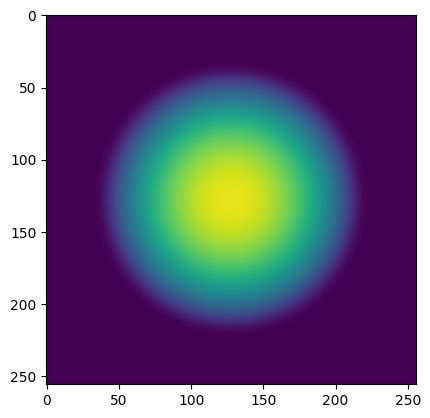

In [19]:
observation, info = env.reset()

plt.imshow(observation[0], vmin=0, vmax=255)
plt.show()

Now, let's take a random action, simulate one step of the environment, and print the reward after one step and the observation after this step.

reward:  0


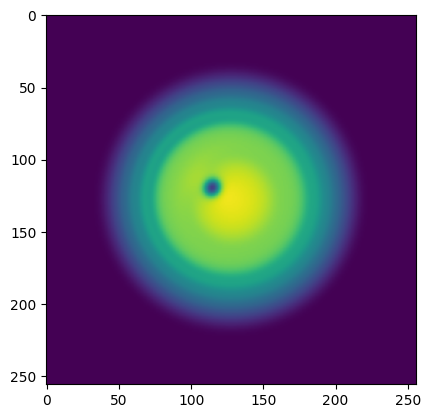

In [20]:
action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(action)
print("reward: ", reward)
plt.imshow(observation[0], vmin=0, vmax=255)
plt.show()

We can simulated one full episode of the environment, taking random actions at each step.
We print the total reward over the episode and visualize an animation of the episode with the reward at each step.

In [21]:
observation, info = env.reset()

episode_over = False
rewards = []
total_reward = 0

iters = 0

observations = []
while not episode_over:
    action = env.action_space.sample()

    observation, reward, terminated, truncated, info = env.step(action)

    total_reward += reward
    episode_over = terminated or truncated
    iters += 1
    rewards.append(reward)
    observations.append(observation[0])

print(f"Episode finished! Total reward: {total_reward}")
env.close()

Episode finished! Total reward: 503


In [22]:
fig, ax = plt.subplots(figsize=(4,4))

ims = []
for i in range(0, len(observations), 2):
    im = ax.imshow(observations[i], animated=True, 
                   vmin=0.0, vmax=255,
                   extent=[domain_.box[0][0], domain_.box[0][1], 
                          domain_.box[1][0], domain_.box[1][1]])
    title = ax.text(0.5, 1.05, f'Step {i}, Reward: {rewards[i]:.2f}',
                    ha='center', transform=ax.transAxes)
    ims.append([im, title])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True)  # Increased interval from 20 to 200 ms

plt.xlabel('x')
plt.ylabel('y')

plt.close()

HTML(ani.to_jshtml())